This is a Colaboratory notebook designed to test the Mesoscopic Analysis Publication

For assistance in understanding, refer to the GradientCrescent Tutorial or Google's own tutorials
https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part3.ipynb#scrollTo=IcYZPBS3bTAj

In [1]:


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
#set randomness for reproducibility

!mkdir data

from numpy.random import seed
#seed(6) #1
from tensorflow import set_random_seed
#set_random_seed(5) #2

#

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os


#TRAINING SETS########################################

#Download the training dataset- 10psi
#!gdown https://drive.google.com/uc?id=1aJvpWIQ6G8fHwRCWRgrtKaKUQ8zaRLsK
#Download the training dataset- 5psi 
!gdown https://drive.google.com/uc?id=1Zxke5rZZOPRNAf0AmETNHUfbn6EPyeYi
  
#Downlaod FFHQ data

!gdown https://drive.google.com/uc?id=1ky465Gxe-7KYF5cheXgxHIkevJu7Ofbc


 

#Unzip all folders

!unzip real.zip -d data    
!unzip stylegan_05psi.zip -d data    

Downloading...
From: https://drive.google.com/uc?id=1Zxke5rZZOPRNAf0AmETNHUfbn6EPyeYi
To: /content/stylegan_05psi.zip
800MB [00:09, 80.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ky465Gxe-7KYF5cheXgxHIkevJu7Ofbc
To: /content/real.zip
682MB [00:08, 80.0MB/s]
Archive:  real.zip
   creating: data/real/
  inflating: data/real/02000.png     
  inflating: data/real/02501.png     
  inflating: data/real/02502.png     
  inflating: data/real/02503.png     
  inflating: data/real/02504.png     
  inflating: data/real/02505.png     
  inflating: data/real/02506.png     
  inflating: data/real/02507.png     
  inflating: data/real/02508.png     
  inflating: data/real/02509.png     
  inflating: data/real/02510.png     
  inflating: data/real/02511.png     
  inflating: data/real/02512.png     
  inflating: data/real/02513.png     
  inflating: data/real/02514.png     
  inflating: data/real/02515.png     
  inflating: data/real/02516.png     
  inflating: data/real/02517.png     

In [2]:
print(os.listdir("/content/"))

#Print and remove zips once done

!rm snow.zip
!rm natural_images_blizzard.zip


['.config', 'stylegan_05psi.zip', 'data', 'real.zip', 'sample_data']
rm: cannot remove 'snow.zip': No such file or directory
rm: cannot remove 'natural_images_blizzard.zip': No such file or directory


Resnet Initialization

In [3]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow as tf


DATASET_PATH  = '/content/data'

IMAGE_SIZE    = (299, 299)
NUM_CLASSES   = 2
BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
FREEZE_LAYERS = 16 # freeze the first this many layers for training
NUM_EPOCHS    = 30
LEARNING_RATE = 0.002 #Slow learn rate as we are transfer training5e-5
DROP_OUT = .5



#Train datagen here is a preprocessor
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')

# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                    fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training",
                                                  class_mode='binary'
                                                  
                                                  )

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  class_mode='binary'
                                                 
                                                 
                                                  )

#MAKE A TEST DATAGEN linking to separate path
#train_batches

#https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Layer Modification at upper layer of Resnet

In [4]:
# build our classifier model based on pre-trained InceptionResNetV2:
# 1. we don't include the top (fully connected) layers of InceptionResNetV2
# 2. we add a DropOut layer followed by a Dense (fully connected)
#    layer which generates softmax class score for each class
# 3. we compile the final model using an Adam optimizer, with a
#    low learning rate (since we are 'fine-tuning')

#If you need help then https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975

#############main portion for vgg16 only##############
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,BatchNormalization,Conv2D,MaxPooling2D,Dropout,Flatten,LeakyReLU
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input
""" 
net = InceptionV3(include_top=False,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=(299,299,3))

# add a global spatial average pooling layer
x = net.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add dropout
x = Dropout(0.5)(x)
# one fully connected layer more
x = Dense(256, activation='relu')(x)
# add dropout
x = Dropout(0.5)(x)
# one fully connected layer more
x = Dense(32, activation='relu')(x)
# and a logistic layer --
predictions = Dense(1, activation='sigmoid')(x)
model = Model(net.input, predictions)

for layer in net.layers[ :90]:
    layer.trainable = False
model.compile(optimizer=Adam(lr=LEARNING_RATE),
                  loss='binary_crossentropy', metrics=['accuracy'])

#   print(net_final.summary())

"""

" \nnet = InceptionV3(include_top=False,\n                        weights='imagenet',\n                        input_tensor=None,\n                        input_shape=(299,299,3))\n\n# add a global spatial average pooling layer\nx = net.output\nx = GlobalAveragePooling2D()(x)\n# let's add a fully-connected layer\nx = Dense(1024, activation='relu')(x)\n# add dropout\nx = Dropout(0.5)(x)\n# one fully connected layer more\nx = Dense(256, activation='relu')(x)\n# add dropout\nx = Dropout(0.5)(x)\n# one fully connected layer more\nx = Dense(32, activation='relu')(x)\n# and a logistic layer --\npredictions = Dense(1, activation='sigmoid')(x)\nmodel = Model(net.input, predictions)\n\nfor layer in net.layers[ :90]:\n    layer.trainable = False\nmodel.compile(optimizer=Adam(lr=LEARNING_RATE),\n                  loss='binary_crossentropy', metrics=['accuracy'])\n\n#   print(net_final.summary())\n\n"

In [5]:
#Meso4 model from mesoscopic analysis.  Input names changed because its easier for feature visualization

#optimizer = Adam(lr = learning_rate)
#self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
x = Input(shape = (299, 299, 3))
        
x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
x4 = BatchNormalization()(x4)
x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
y = Flatten()(x4)
y = Dropout(0.5)(y)
y = Dense(16)(y)
y = LeakyReLU(alpha=0.1)(y)
y = Dropout(0.5)(y)
y = Dense(1, activation = 'sigmoid')(y)
   
model = Model(inputs = x, outputs = y)
  
  

model.compile(optimizer=Adam(lr=LEARNING_RATE),
                  loss='binary_crossentropy', metrics=['accuracy'])


W0822 01:35:55.743986 139923424630656 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0822 01:35:56.353701 139923424630656 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 299, 299, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 299, 299, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 8)       1608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 8)       32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 8)         0     

Training

In [7]:
#FIT MODEL
result=model.fit_generator(train_batches,
                        steps_per_epoch = 100,
                        validation_data = valid_batches,
                        validation_steps =50,
                        epochs = NUM_EPOCHS,
#                         
                       )

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/30


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


100/100 [==============================] - 293s 3s/step - loss: 0.8349 - acc: 0.5494 - val_loss: 0.9360 - val_acc: 0.4979
Epoch 2/30
100/100 [==============================] - 270s 3s/step - loss: 0.7377 - acc: 0.5537 - val_loss: 0.7229 - val_acc: 0.5084
Epoch 3/30
100/100 [==============================] - 272s 3s/step - loss: 0.7011 - acc: 0.5644 - val_loss: 0.8746 - val_acc: 0.5014
Epoch 4/30
100/100 [==============================] - 270s 3s/step - loss: 0.6879 - acc: 0.5838 - val_loss: 0.7517 - val_acc: 0.5161
Epoch 5/30
100/100 [==============================] - 269s 3s/step - loss: 0.6704 - acc: 0.5987 - val_loss: 0.6835 - val_acc: 0.5712
Epoch 6/30
100/100 [==============================] - 268s 3s/step - loss: 0.6596 - acc: 0.6016 - val_loss: 0.7004 - val_acc: 0.5831
Epoch 7/30
100/100 [==============================] - 272s 3s/step - loss: 0.6505 - acc: 0.6106 - val_loss: 0.6957 - val_acc: 0.6124
Epoch 8/30
100/100 [==============================] - 270s 3s/step - loss: 0.645

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/30


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


100/100 [==============================] - 293s 3s/step - loss: 0.8349 - acc: 0.5494 - val_loss: 0.9360 - val_acc: 0.4979
Epoch 2/30
100/100 [==============================] - 270s 3s/step - loss: 0.7377 - acc: 0.5537 - val_loss: 0.7229 - val_acc: 0.5084
Epoch 3/30
100/100 [==============================] - 272s 3s/step - loss: 0.7011 - acc: 0.5644 - val_loss: 0.8746 - val_acc: 0.5014
Epoch 4/30
100/100 [==============================] - 270s 3s/step - loss: 0.6879 - acc: 0.5838 - val_loss: 0.7517 - val_acc: 0.5161
Epoch 5/30
100/100 [==============================] - 269s 3s/step - loss: 0.6704 - acc: 0.5987 - val_loss: 0.6835 - val_acc: 0.5712
Epoch 6/30
100/100 [==============================] - 268s 3s/step - loss: 0.6596 - acc: 0.6016 - val_loss: 0.7004 - val_acc: 0.5831
Epoch 7/30
100/100 [==============================] - 272s 3s/step - loss: 0.6505 - acc: 0.6106 - val_loss: 0.6957 - val_acc: 0.6124
Epoch 8/30
100/100 [==============================] - 270s 3s/step - loss: 0.645

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


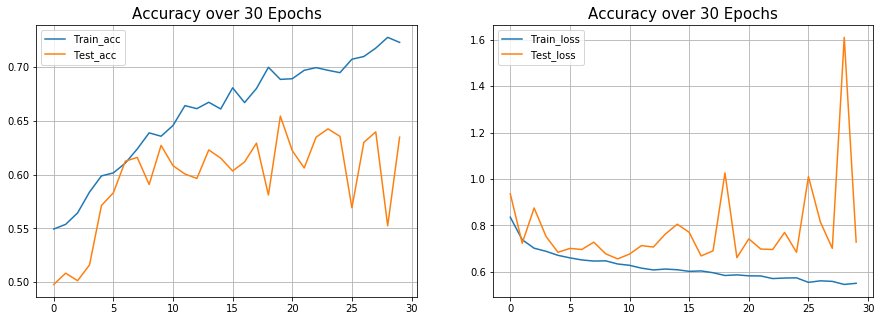

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


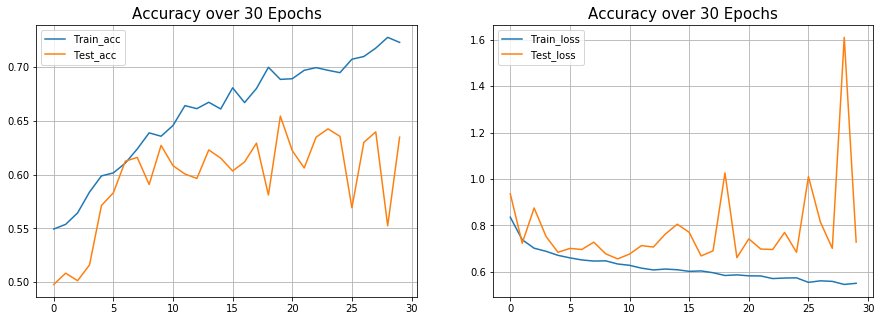

In [8]:
import matplotlib.pyplot as plt


def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(epochs), acc, label='Train_acc')
    plt.plot(range(epochs), val_acc, label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(epochs), loss, label='Train_loss')
    plt.plot(range(epochs), val_loss, label='Test_loss')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(result, 30)

In [9]:
model.compile(optimizer=Adam(lr=0.0002),
                  loss='binary_crossentropy', metrics=['accuracy'])

result=model.fit_generator(train_batches,
                        steps_per_epoch = 100,
                        validation_data = valid_batches,
                        validation_steps =50,
                        epochs = 20,
#                         
                       )

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


100/100 [==============================] - 297s 3s/step - loss: 0.5488 - acc: 0.7287 - val_loss: 0.6470 - val_acc: 0.6732
Epoch 2/20
100/100 [==============================] - 276s 3s/step - loss: 0.5149 - acc: 0.7462 - val_loss: 0.6549 - val_acc: 0.6739
Epoch 3/20
100/100 [==============================] - 272s 3s/step - loss: 0.5098 - acc: 0.7519 - val_loss: 0.7011 - val_acc: 0.6557
Epoch 4/20
100/100 [==============================] - 276s 3s/step - loss: 0.5006 - acc: 0.7584 - val_loss: 0.6389 - val_acc: 0.6781
Epoch 5/20
 33/100 [========>.....................] - ETA: 1:33 - loss: 0.4967 - acc: 0.7557

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


100/100 [==============================] - 297s 3s/step - loss: 0.5488 - acc: 0.7287 - val_loss: 0.6470 - val_acc: 0.6732
Epoch 2/20
100/100 [==============================] - 276s 3s/step - loss: 0.5149 - acc: 0.7462 - val_loss: 0.6549 - val_acc: 0.6739
Epoch 3/20
100/100 [==============================] - 272s 3s/step - loss: 0.5098 - acc: 0.7519 - val_loss: 0.7011 - val_acc: 0.6557
Epoch 4/20
100/100 [==============================] - 276s 3s/step - loss: 0.5006 - acc: 0.7584 - val_loss: 0.6389 - val_acc: 0.6781
Epoch 5/20
100/100 [==============================] - 276s 3s/step - loss: 0.5018 - acc: 0.7588 - val_loss: 0.6776 - val_acc: 0.6606
Epoch 6/20
100/100 [==============================] - 278s 3s/step - loss: 0.5013 - acc: 0.7541 - val_loss: 0.6323 - val_acc: 0.6725
Epoch 7/20
100/100 [==============================] - 279s 3s/step - loss: 0.4946 - acc: 0.7638 - val_loss: 0.6354 - val_acc: 0.6781
Epoch 8/20
100/100 [==============================] - 274s 3s/step - loss: 0.498

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:7

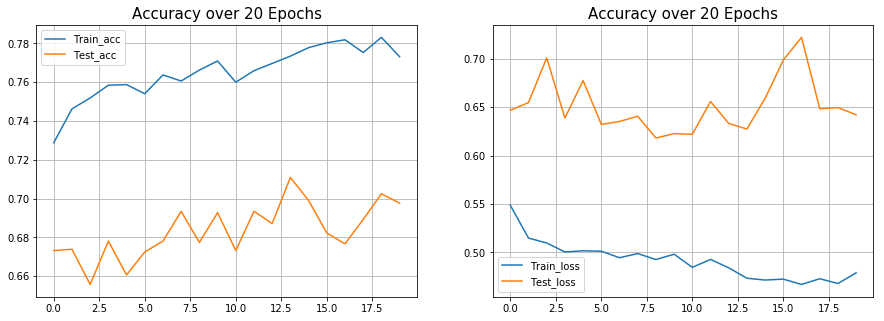

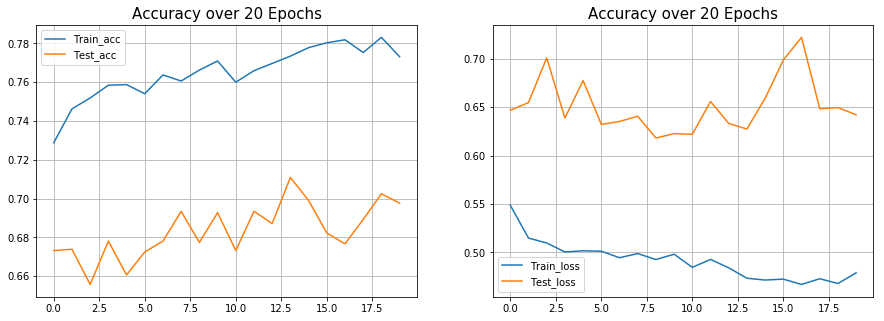

In [10]:
def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(epochs), acc, label='Train_acc')
    plt.plot(range(epochs), val_acc, label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(epochs), loss, label='Train_loss')
    plt.plot(range(epochs), val_loss, label='Test_loss')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(result, 20)


#model.save('stylgen_recog_meso4_10.h5')

In [11]:
# save trained weights
# net_final.save(WEIGHTS_FINAL)
x = net_final.evaluate_generator(valid_batches,
                           steps = np.ceil(len(valid_batches) / BATCH_SIZE),
                           use_multiprocessing = True,
                           verbose = 1
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])

#net_final.save('stylgen_recog_styled_10.h5')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:7

NameError: ignored

NameError: ignored

Predict

In [0]:
#Evaluate on test dataset - TODO: actually import the test dataset define TESTdir, we also have to name all of it as CAR

""" 
eval_generator = train_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size=20,
        class_mode='categorical')
eval_generator.reset()    
pred = net_final.predict_generator(eval_generator,1000,verbose=1)
print("Predictions finished")


#Map the predictions to the training classes
#First, take max prediction class
predicted_class_indices=np.argmax(pred,axis=1)

#Map it to train generataor
labels = (train_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
"""

Save

In [0]:
#Save results
""" 
filenames=eval_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("finalresultsVGG16_stylegan.csv",index=False)
"""